# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: Васильев Руслан

Дата выдачи: 18 марта 00:00

Мягкий дедлайн: 1 апреля 23:59 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet. 

Ссылка на данные: https://yadi.sk/d/-ug82uwhSuLYrA

## <font color=blue>Утилиты</font>

In [1]:
%%script bash
wget https://getfile.dokpub.com/yandex/get/https://yadi.sk/d/-ug82uwhSuLYrA\
     -q -O people_data.zip
unzip -q people_data.zip

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler
plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('font', family='serif', size=11)
plt.rc('axes', prop_cycle=cycler(color='bmrgcyk'))

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [3]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

<font color=blue>Будем подгружать изображения при индексации, на этапе инициализации запомним пути к фото и соответствующим маскам.</font>

In [4]:
import os
from torchvision.transforms import Compose
from PIL import Image

class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.img_dir = images_dir
        self.mask_dir = target_dir
        if transforms is None:
            transforms = []
        self.transform = Compose(transforms)

        img_ext = os.path.splitext(os.listdir(images_dir)[0])[1]
        names = [os.path.splitext(img_name)[0] for img_name
                 in os.listdir(images_dir)]
        self.img_paths = [os.path.join(images_dir, name) + img_ext
                          for name in names]
        if target_dir is not None:
            mask_ext = os.path.splitext(os.listdir(target_dir)[0])[1]
            self.mask_paths = [os.path.join(target_dir, name) + mask_ext
                               for name in names]

    def __len__(self):
        return len(self.img_paths)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        image = Image.open(self.img_paths[idx])
        if self.mask_dir is not None:
            mask = Image.open(self.mask_paths[idx])
            return self.transform((image, mask))
        else:
            return self.transform(image), None

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

<font color=blue>Поскольку некоторые трансформации применяются и к маске, и к изображению, реализуем их следующим образом: каждый трансформер для датасета будет принимать  и выдавать пару (изображение, маска), где трансформация, возможно, применяется только к изображению. Из минусов подхода — необходимость сделать обертки для всех преобразований. Основной плюс — стандартизация интерфейса — возможность в классе `PhotosDataset` все преобразования положить в `torchvision.transforms.Compose` и просто пропускать через него пары.</font>

In [5]:
from torchvision.transforms import ToTensor, Normalize
from PIL.ImageEnhance import Brightness as BrightEnhancer

In [6]:
#@title
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, pair):
        if torch.rand(1) < self.p:
            return tuple(pic.transpose(Image.FLIP_LEFT_RIGHT) for pic in pair)
        return pair

In [7]:
#@title
class RandomCrop:
    def __init__(self, p=0.5, size=None, keep_input_size=True):
        '''
        Crop the image on random location with probability p.
        Size can be tuple or None to be chosen randomly (random
        size is at least input size / 2). If keep_input_size
        is True the cropped image is resized to the input shape.
        '''
        self.p = p
        self.size = size
        self.keep_input_size = True

    def __call__(self, pair):
        if torch.rand(1) > self.p:
            return pair
        old_size = pair[0].size
        if self.size is None:
            new_size = [torch.randint(old_size[i] // 2, old_size[i], (1,)).item()
                        for i in range(2)]
        else:
            new_size = self.size
        box = [0] * 4
        for i in range(2):
            box[i] = torch.randint(0, old_size[i]-new_size[i]+1, (1,)).item()
            box[i+2] = box[i] + new_size[i]
        cropped_pair = tuple(pair[i].crop(box) for i in range(2))
        if self.keep_input_size:
            cropped_pair = tuple(cropped_pair[i].resize(old_size) for i in range(2))
        return cropped_pair

In [8]:
#@title
class RandomBrightness:
    def __init__(self, p=0.5, factor_range=(0.9, 2.0), delta=None):
        '''
        Randomly with probability p adjust brightness of image:
            - to 1 + delta if delta is not None,
            - chosen uniformly from factor_range otherwise.
        '''
        self.p = p
        self.factor_range = factor_range
        if delta is not None:
            self.factor = 1 + delta
        else:
            self.factor = None
    
    def get_factor_(self):
        if self.factor is not None:
            return self.factor
        return torch.empty(1).uniform_(*self.factor_range).item()

    def __call__(self, pair):
        if torch.rand(1) < self.p:
            new_img = BrightEnhancer(pair[0]).enhance(self.get_factor_())
            return new_img, pair[1]
        return pair

In [9]:
#@title
class RandomBackground:
    def __init__(self, p=0.1, backgrounds=None):
        self.p = p
        self.backgrounds = backgrounds

    def __call__(self, pair):
        if torch.rand(1) > self.p:
            return pair
        background = Image.open(self.backgrounds[
            torch.randint(0, len(self.backgrounds), (1,)).item()])
        # assert background.size == pair[0].size
        new_img = Image.composite(pair[0], background, pair[1])
        return new_img, pair[1]

In [10]:
#@title
class ToTensors:
    def __init__(self):
        self.to_tensor = ToTensor()
    def __call__(self, pair):
        return self.to_tensor(pair[0]), self.to_tensor(pair[1])

class NormalizeImage:
    def __init__(self, mean, std):
        self.normalize = Normalize(mean, std)

    def __call__(self, pair):
        return self.normalize(pair[0]), pair[1]

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

<font color=blue>Добавим все реализованные случайные преобразования:</font>

In [11]:
DATA_PATH = 'people_data/'

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms=[
        RandomBackground(p=0.4, backgrounds=None),
        RandomHorizontalFlip(p=0.5),
        RandomBrightness(p=0.5, factor_range=(0.8, 1.8)),
        RandomCrop(p=0.3, size=(180, 240)),
        ToTensors(),
        NormalizeImage(mean=mean, std=std),
    ]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=[
        ToTensors(),
        NormalizeImage(mean=mean, std=std),
    ]
)

<font color=blue>В качестве списка фонов возьмем ту же обучающую выборку:</font>

In [12]:
train_dataset.transform.transforms[0].backgrounds = train_dataset.img_paths

Функция для отображения изображения:

In [13]:
#@title
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)

    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

<font color=blue>Функция для отображения нескольких изображений и масок:</font>

In [14]:
def show_idx_images_sample(dataset, idx, grid=(3, 6)):
    plt.figure(figsize=(grid[1] * 2, grid[0] * 2.66))
    for i in range(grid[0]):
        for j in range(grid[1] // 2):
            img, mask = dataset[idx]
            img = np.clip(img.permute(1, 2, 0).numpy() * mean + std, 0, 1)
            mask = mask.squeeze().numpy()
            plt.subplot(*grid, 1 + i * grid[1] + j * 2)
            plt.imshow(img)
            plt.axis('off')
            plt.subplot(*grid, 1 + i * grid[1] + j * 2 + 1)
            plt.imshow(mask)
            plt.axis('off')
    plt.tight_layout()

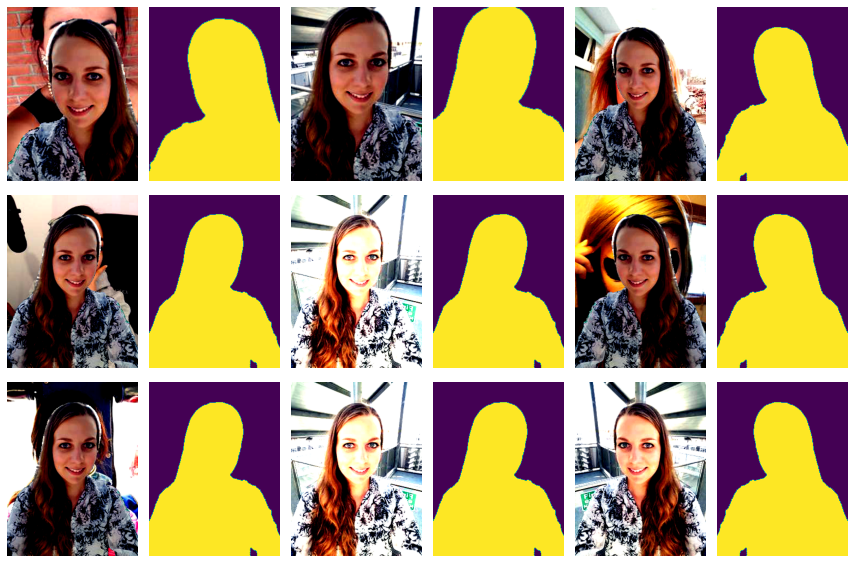

In [15]:
show_idx_images_sample(train_dataset, 0)

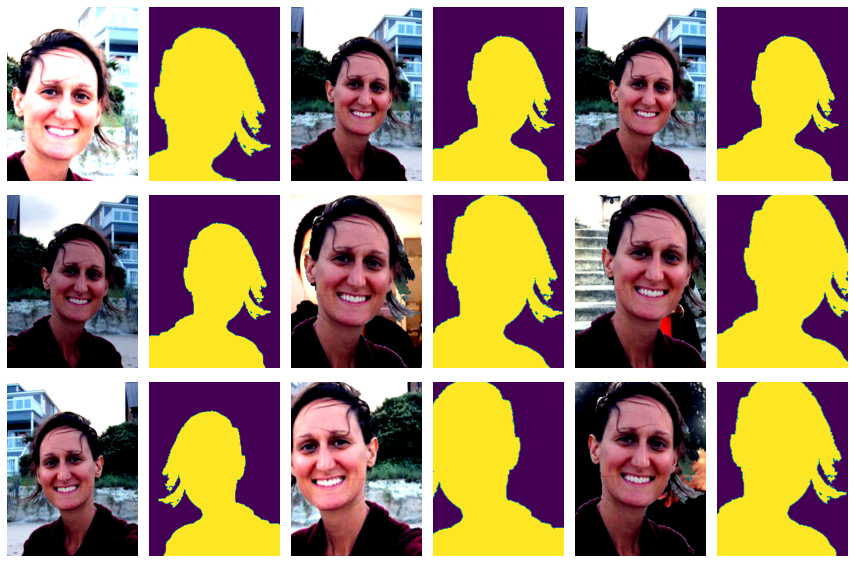

In [16]:
show_idx_images_sample(train_dataset, 1)

<font color=blue>За счет большого числа случайных преобразований получаем много данных почти бесплатно ;)</font>

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [17]:
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=2,
                               shuffle=True,)
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=2)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):
        if self.with_logits:
            logits = torch.sigmoid(logits)
        loss_batches = 1 - 2 * (logits * true_labels).sum(axis=(-2, -1)) / (
            logits.sum(axis=(-2, -1)) + true_labels.sum(axis=(-2, -1)) + self.eps
        )
        if self.reduction == 'sum':
            loss_value = loss_batches.sum()
        elif self.reduction == 'mean':
            loss_value = loss_batches.mean()
        elif self.reduction is None:
            loss_value = loss_batches
        return loss_value

Проверка реализации:

In [19]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet (https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [20]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [21]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [22]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [23]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [24]:
#@title
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

### <font color=blue>Реализации основных функций для экспериментов</font>

In [25]:
#@title IoU implementation

class IoU(nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):  
        if self.with_logits:
            logits = torch.sigmoid(logits)
        pred_positive = logits > 0.5
        positive = true_labels.bool()
        iou_batches = (((pred_positive & positive).sum(axis=(-2, -1)) + self.eps) /
                       ((pred_positive | positive).sum(axis=(-2, -1)) + self.eps))
        if self.reduction == 'sum':
            loss_value = iou_batches.sum()
        elif self.reduction == 'mean':
            loss_value = iou_batches.mean()
        elif self.reduction is None:
            loss_value = iou_batches
        return loss_value

In [26]:
#@title Train functions

from tqdm.notebook import tqdm

def train_batch(model, x_batch, y_batch,
                loss_func, optimizer):
    model.train()
    model.zero_grad()
    output = model(x_batch)
    loss = loss_func(output, y_batch)
    loss.backward()
    optimizer.step()
    return loss.cpu().item()

def train_epoch(model, dataloader,
                loss_func, optimizer, callback=None):
    epoch_loss = 0.0
    epoch_size = 0
    for i_batch, (batch_x, batch_y) in enumerate(dataloader):
        batch_loss = train_batch(model,
            batch_x.to(model.device), batch_y.to(model.device),
            loss_func, optimizer)
        if callback is not None:
            callback(model, batch_loss)
        epoch_size += len(batch_x)
        epoch_loss += batch_loss * len(batch_x)
        dataloader.set_description(f'Batch loss: {batch_loss:.5f}')
    return epoch_loss / epoch_size

def train_full(model, dataloader,
               loss_func, optimizer,
               n_epochs, callback=None):
    epochs = tqdm(range(n_epochs), desc='Epoch')
    for i_epoch in epochs:
        tqdm_dataloader = tqdm(dataloader, leave=False, desc='Batch', display=False)
        epoch_loss = train_epoch(model, tqdm_dataloader, loss_func, optimizer)
        epochs.set_description(f'Epoch loss: {epoch_loss:.5f}')
        if callback is not None:
            cb_dict = callback(model, epoch_loss)
            epochs.set_postfix(cb_dict)

In [27]:
#@title Evaluation

def eval_loss_metric(model, dataloader, loss_func, metric_funcs):
    model.eval()
    loss, total = 0.0, 0
    metrics = dict.fromkeys(metric_funcs.keys(), 0.0)
    tqdm_dataloader = tqdm(dataloader, desc='Test batches...', leave=False, display=False)
    with torch.no_grad():
        for batch_x, batch_y in tqdm_dataloader:
            total += len(batch_x)
            output = model(batch_x.to(model.device)).cpu()
            loss += loss_func(output, batch_y).item() * len(batch_x)
            for name in metric_funcs:
                metrics[name] += metric_funcs[name](output, batch_y).item() * len(batch_x)
    for name in metric_funcs:
        metrics[name] /= total
    return loss / total, metrics

def plot_batch(model, dataloader):
    model.eval()
    batch_x, batch_y = next(iter(dataloader))
    with torch.no_grad():
        output = model(batch_x.to(model.device)).cpu()
    sigmoids = torch.sigmoid(output)
    ssize = len(batch_x)
    plt.figure(figsize=(9, 8))
    for i in range(ssize // 2):
        for j in range(2):
            plt.subplot(ssize // 2, 6, 1 + i * 6 + j * 3)
            img = np.clip(batch_x[i * 2 + j].permute(1, 2, 0).numpy() * mean + std, 0, 1)
            plt.imshow(img)
            plt.axis('off')
            plt.subplot(ssize // 2, 6, 2 + i * 6 + j * 3)
            plt.imshow(batch_y[i * 2 + j].squeeze())
            plt.axis('off')
            plt.subplot(ssize // 2, 6, 3 + i * 6 + j * 3)
            plt.imshow(sigmoids[i * 2 + j].squeeze())
            plt.axis('off')
    plt.tight_layout()

In [28]:
#@title CallBack

from collections import defaultdict

class CallBack:
    def __init__(self, eval_func, name=None):
        self.eval_func = eval_func
        self.train_losses = []
        self.test_losses = []
        self.test_metrics = defaultdict(list)
        self.name = name

    def __call__(self, model, train_loss):
        self.train_losses.append(train_loss)
        test_loss, test_metrics = self.eval_func(model)
        self.test_losses.append(test_loss)
        for name in test_metrics:
            self.test_metrics[name].append(test_metrics[name])
        return test_metrics

    def plot(self):
        xs = np.arange(n_epochs) + 1
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.title('Loss functions')
        plt.ylabel('loss')
        plt.xlabel('epoch')

        plt.plot(xs, self.train_losses, label='train (rand aug)')
        plt.plot(xs, self.test_losses, label='test')
        plt.legend()

        plt.subplot(122)
        plt.title('Evaluation metrics (test)')
        plt.ylabel('metric')
        plt.xlabel('epoch')

        plt.plot(xs, self.test_metrics['IoU'], label='IoU')
        dice_coef = [1 - loss for loss in self.test_metrics['DiceLoss']]
        plt.plot(xs, dice_coef, label='Dice')
        plt.legend()

        plt.suptitle(self.name, y=1.03)
        plt.tight_layout()

In [29]:
!mkdir models

In [30]:
#@title Experiment

from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 15

def experiment_cb(net_class, loss_func, name=None):
    net = net_class()
    net.to(device)
    net.device = device

    optimizer = torch.optim.Adam(net.parameters(), lr=2e-5)

    metric_dict = {
        'IoU': IoU(reduction='mean'),
        'DiceLoss': DiceLoss(reduction='mean'),
    }

    eval_here = partial(eval_loss_metric, dataloader=test_data_loader,
        loss_func=loss_func, metric_funcs=metric_dict)
    cb = CallBack(eval_here, name)

    train_full(net, train_data_loader, loss_func, optimizer, n_epochs, cb)
    plot_batch(net, test_data_loader)
    torch.save(net, 'models/' + name + '.pth')
    return cb

### <font color=blue>Cross entropy loss</font>

<font color=blue>Мы сделали обертки для всех этапов обучения, оценки, а также для построения графиков и вывода примеров.</font>

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

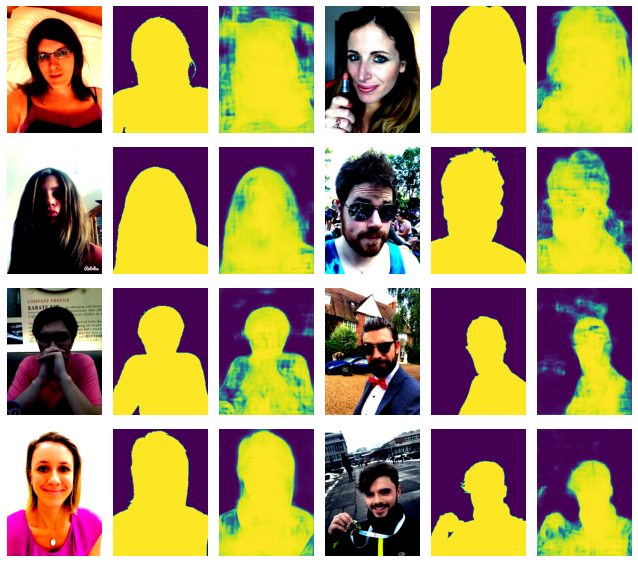

In [31]:
cb_u_ce = experiment_cb(UNet, torch.nn.BCEWithLogitsLoss(reduction='mean'),
                        'UNet, learning with cross entropy loss')

<font color=blue>Здесь и далее после обучения сети, помимо информации по времени (tqdm), выводятся примеры ее работы на тесте в виде троек: исходная фотография, маска и небинаризованная предсказанная маска.</font>

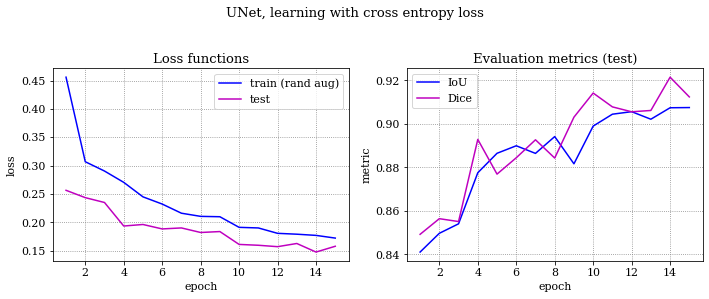

In [32]:
cb_u_ce.plot()

<font color=blue>А затем мы строим два графика: для лосса (в каждом эксперименте свой) и метрик (используем IoU — intersection ove union, а также Dice, в случае метрики получаемый как $[$1 - DiceLoss$]$). Причем можно видеть, что лосс на обучении хуже лосса на тесте. Это особенность связана с тем, что лосс трейна усредняется напосредственно во время обучения, в то время как для теста он считается по прошествии эпохи. Другая причина — достаточно агрессивная аугментация: случайных преобразований много и они все время изменяют изображения на обучении, в то время как тестовая выборка состоит из стандартных фотографий.</font>

<font color=blue>Итак, на кросс-энтропии сеть уже показывает хорошее качество сегментации. Обучение одной эпохи занимает $\approx$50 секунд.</font>

### <font color=blue>Dice loss</font>

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

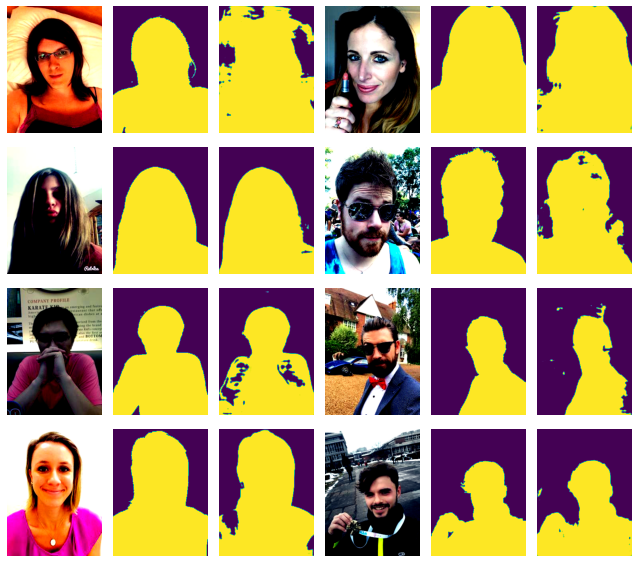

In [33]:
cb_u_dice = experiment_cb(UNet, DiceLoss(reduction='mean'),
                          'UNet, learning with Dice loss')

<font color=blue>Сравнивая изображения с предыдущим экспериментом, видим, что сеть выдает большие значения уверенностей (меньше «зеленых» участков). Немного увеличилось число «артефактов».</font>

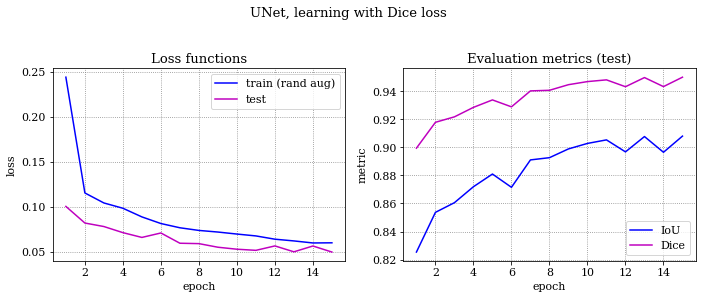

In [34]:
cb_u_dice.plot()

<font color=blue>Чего и следовало ожидать — метрика Dice заметно лучше при настройке на DiceLoss. IoU осталась примерно такой же, как и в предыдущем эксперименте. </font>

### <font color=blue>Cross entropy loss + Dice loss</font>

In [35]:
class WeightedDiceCE:
    def __init__(self, dice_weight=0.5, reduction='mean'):
        self.dice_weight = dice_weight
        self.dice = DiceLoss(reduction=reduction)
        self.ce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
    def __call__(self, output, target):
        return (self.dice_weight * self.dice(output, target) +
                (1 - self.dice_weight) * self.ce(output, target))

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

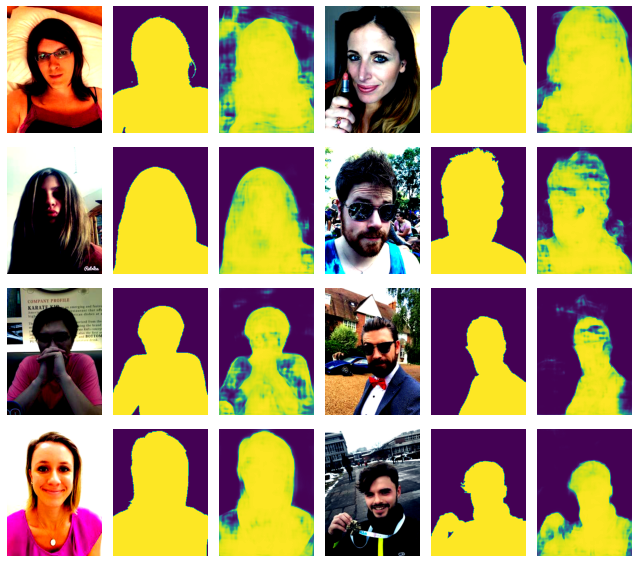

In [36]:
cb_u_dice_ce = experiment_cb(UNet, WeightedDiceCE(),
                             'UNet, learning with CE + Dice loss')

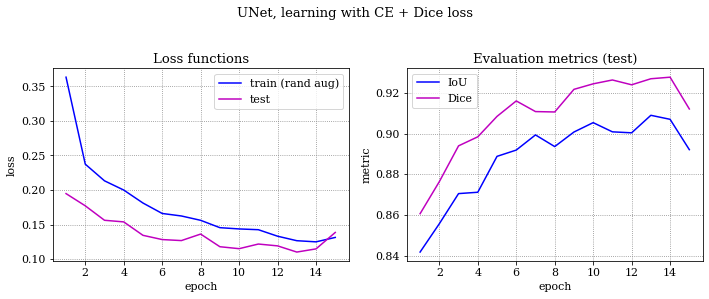

In [37]:
cb_u_dice_ce.plot()

<font color=blue>Здесь на последних итерации видим падение качества. С этой проблемой можно бороться с помощью уменьшения темпа обучения с ростом номера эпохи, а регуляризацией. Интересно, что маски, выведенные в качестве примеров, действительно представляют собой нечто среднее между первыми двумя экспериментами.</font>

<font color=blue>Лучше всего по результатам экспериментов с UNet работает обучение на DiceLoss, хотя при этом сеть страдает переуверенностью. Качество при обучении с кросс-энтропией (1 и 3 эксперименты) менее стабильное. Причиной могут быть «взрывы градиента» или как раз с участки изображений, в которых небинаризованные вероятности близки к 0.5 — значения на них то выше, то ниже порога.</font>

<font color=blue>При всех стратегиях сети достигали качества на тесте больше $90\%$.</font>

## LinkNet (2 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

Обучите сеть и проведите анализ согласно предыдущему пункту.

<font color=blue>Действительно, конкатенация тензоров при декодировании заменяется на поэлементное суммирование.</font>

In [38]:
class LNDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(left + x))
        x = self.relu(self.conv2(x))
        return x

class LNDecoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', LNDecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [39]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = LNDecoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

### <font color=blue>Cross entropy loss</font>

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

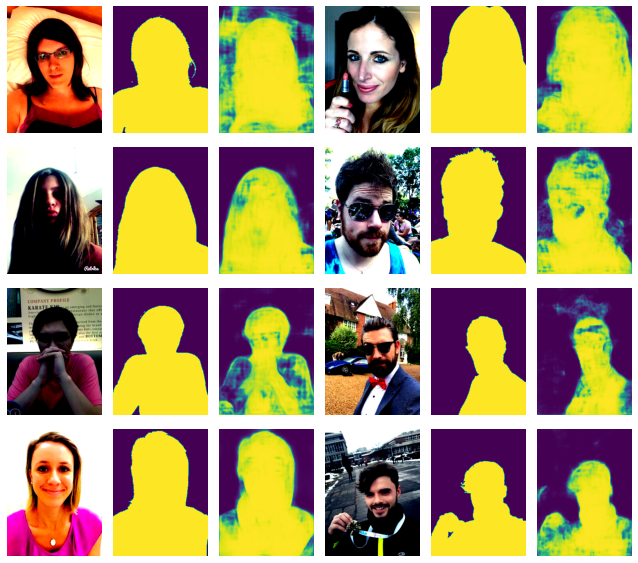

In [40]:
cb_ln_ce = experiment_cb(LinkNet, torch.nn.BCEWithLogitsLoss(reduction='mean'),
                        'LinkNet, learning with cross entropy loss')

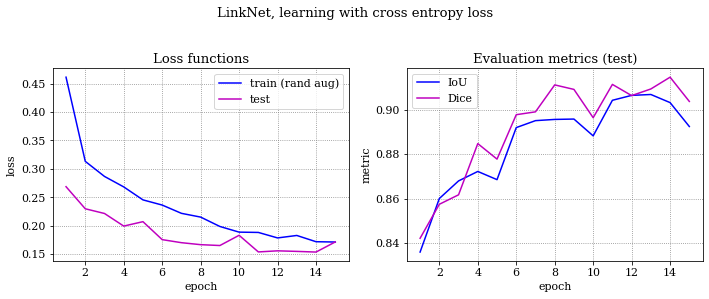

In [41]:
cb_ln_ce.plot()

<font color=blue>В первом эксперименте с LinkNet видим все те же особенности обучения на кросс-энтропию — отсутствие стабильности в качестве, несмотря на относительно ровную кривую лосса на трейне.</font>

### <font color=blue>Dice loss</font>

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

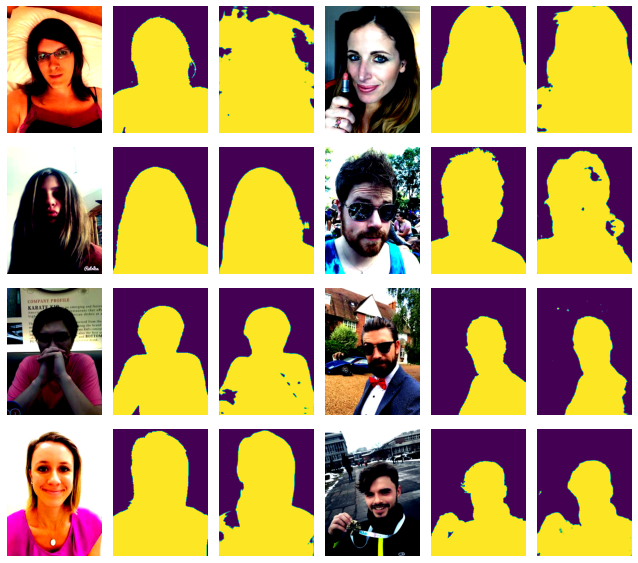

In [42]:
cb_ln_dice = experiment_cb(LinkNet, DiceLoss(reduction='mean'),
                        'LinkNet, learning with Dice loss')

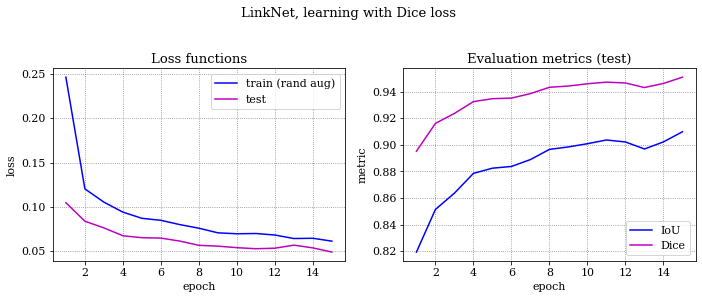

In [43]:
cb_ln_dice.plot()

<font color=blue>Пожалуй, это самый удачный эксперимент на текущий момент: кривые функции потерь и качества достаточно монтоннны. Особенности DiceLoss (переуверенность) по-прежнему свойственны выходным маскам.</font>

### <font color=blue>Cross entropy loss + Dice loss</font>

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



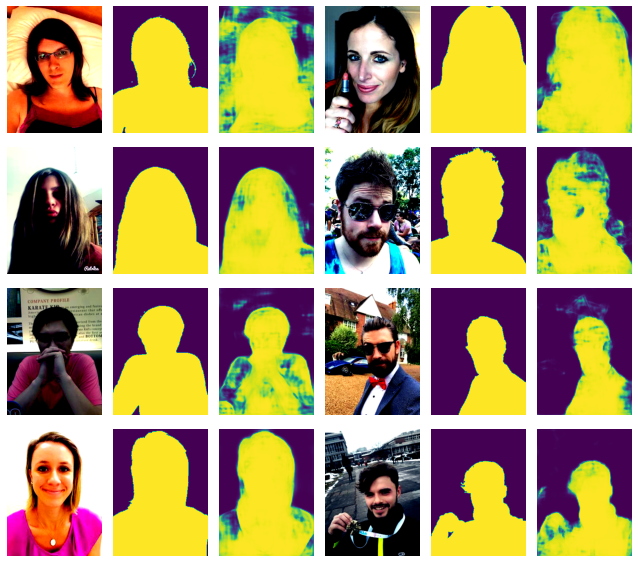

In [44]:
cb_ln_dice_ce = experiment_cb(LinkNet, WeightedDiceCE(),
                             'LinkNet, learning with CE + Dice loss')

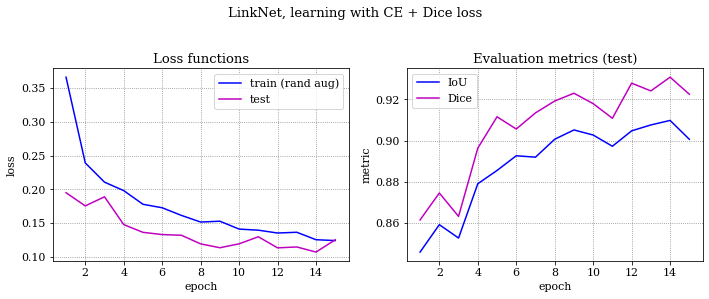

In [45]:
cb_ln_dice_ce.plot()

<font color=blue>И здесь с точки зрения кривых ситуация аналогична эксперименту с UNet: примеры изображений взяли в первую очередь худшее из двух подходов. Тем не менее на предпоследней итерации качество одно из лучших.</font>

### <font color=blue>Сравнение всех моделей</font>

<font color=blue>Самое заметное отличие между UNet и LinkNet в наших экспериментах — скорость обучения (соответственно 50 и 40 секунд на эпоху в среднем). Это логично: при конкатенации размер тензора в два раза больше, чем при поэлементном сложении.</font>

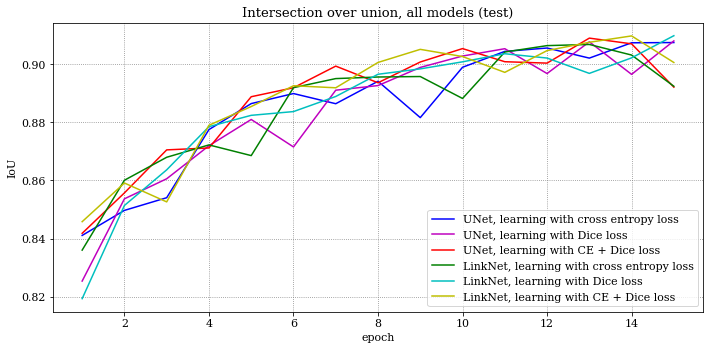

In [46]:
import pickle

cbs = [cb_u_ce, cb_u_dice, cb_u_dice_ce,
       cb_ln_ce, cb_ln_dice, cb_ln_dice_ce]
pickle.dump(cbs, open('cbs.pickle', 'wb'))
xs = np.arange(n_epochs) + 1

plt.figure(figsize=(10, 5))
for cb in cbs:
    plt.plot(xs, cb.test_metrics['IoU'], label=cb.name)
plt.legend()
plt.title('Intersection over union, all models (test)')
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.tight_layout()

<font color=blue>Итак, DiceLoss оказалась наиболее удачной функцией потерь в обеих архитектурах нейросетей. С кросс-энтропией обучение менее стабильное (с оговоркой на то, что можно было бы уменьшать темп). В то же время, сразу после первой эпохи при стратегии с DiceLoss у сетей наоборот самое низкое качество.</font>

<font color=blue>В целом, отличия всех 6 комбинаций находится в пределах погрешности, посколько основные идеи остались неизменными: аугментация данных, использование предобученных блоков в энкодере, прокидывание связей в декодере (посредством конкатенации или суммы).</font>

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура сверточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

<font color=blue>1. Локальность. Под локальностью подразумевается, что части паттернов, позволяющих классифицировать изображение, расположены достаточно близко друг к другу. В таком случае свертки позволяют эффективно собрать информацию с данных участков: нейроны связаны не «каждый с каждым» (MLP), а локально. Преимущества: уменьшается переобучение (нет, например, настройки на далекие друг от друга пиксели), а также устойчивость к небольшим сдвигам этих паттернов.</font>

<font color=blue>2. Предположение, что паттерны в изображении повторяются. Под этим подразумевается наличие текстуры. В этом случае операция одной свертки для всего изображение естественно. Преимущество — разделение параметров позволяет быстрее обучаться (в отличие от MLP число параметров существенно меньше).</font>

<font color=blue>Примеры входных данных, в которых данные предположения не выполняются:</font>
* <font color=blue>Данные, на которых однородная информация рассредоточена. Пример: изображение надписи, фрагменты которой расположены в противоположных углах картинки.</font>
* <font color=blue>Чересчур большие изображения. В таком случае патерны на изображении сами по себе будут слишком большие, чтобы их покрыть, понадобится увеличить размер ядра свертки. Это может снова привести к переобучению.</font>
* <font color=blue>Изображения могут вообще не иметь текстур — например, бинарные картинки с разными геометрическими фигурами. Тем не менее в таком случае выполняется первое предположение.</font>

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

<font color=blue>Для $f(\cdot)$ имеем:</font>

1. Размерность выходного пространства: <font color=blue>100</font>
2. Количество обучаемых параметров: <font color=blue>100 000</font>
3. Число операций на forward'е: <font color=blue>100 000 умножений, 99 000 сложений, 1000 применений $\sigma(\cdot)$.</font>

<font color=blue>Для $g(\cdot)$ имеем:</font>

1. Размерность выходного пространства: <font color=blue>100$\times$10</font>
2. Количество обучаемых параметров: <font color=blue>30</font>
3. Число операций на forward'е: <font color=blue>3000 умножений, 2000 сложений, 1000 применений $\sigma(\cdot)$</font>

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

<font color=blue>Возьмем лучшую из ранее обученных сетей и преобразуем ее выходы: удалим артефакты вне основного изображения, а также заполним дыры внутри.</font>

In [48]:
from skimage.morphology import remove_small_objects, remove_small_holes

def morph(out):
    bin_out = (out.squeeze() > .5).numpy()
#     bin_out = binary_opening(bin_out, disk(5))
    bin_out = remove_small_objects(bin_out, min_size=1e4)
    bin_out = remove_small_holes(bin_out, area_threshold=1e3)
    return bin_out[None]

model_path = 'models/LinkNet, learning with Dice loss.pth'
model = torch.load(model_path)
metric = IoU(reduction=None, with_logits=False)

batch_xs, batch_ys = [], []
bin_outputs, post_outputs = [], []
iou_raws, iou_posts = [], []

tqdm_dataloader = tqdm(test_data_loader, desc='Test batches...')
with torch.no_grad():
    for batch_x, batch_y in tqdm_dataloader:
#         output = torch.sigmoid(model(batch_x.to(model.device))).cpu()
        bin_output = (torch.sigmoid(model(batch_x.to(model.device))) > .5).cpu()
        post_output = torch.stack([torch.from_numpy(morph(out))
                                   for out in bin_output])
        batch_xs.append(batch_x)
        batch_ys.append(batch_y)
        bin_outputs.append(bin_output)
        post_outputs.append(post_output)
        iou_raws.append(metric(bin_output, batch_y))
        iou_posts.append(metric(post_output, batch_y))

batch_xs = torch.cat(batch_xs)
batch_ys = torch.cat(batch_ys)
bin_outputs = torch.cat(bin_outputs)
post_outputs = torch.cat(post_outputs)
iou_raws = torch.cat(iou_raws)
iou_posts = torch.cat(iou_posts)

Test batches...:   0%|          | 0/18 [00:00<?, ?it/s]

In [49]:
print(f'Mean IoU before post processing: {iou_raws.mean().item()}')
print(f'After: {iou_posts.mean().item()}')

Mean IoU before post processing: 0.909853994846344
After: 0.9185947775840759


<font color=blue>Нам удалось добиться прироста в качестве :)</font>

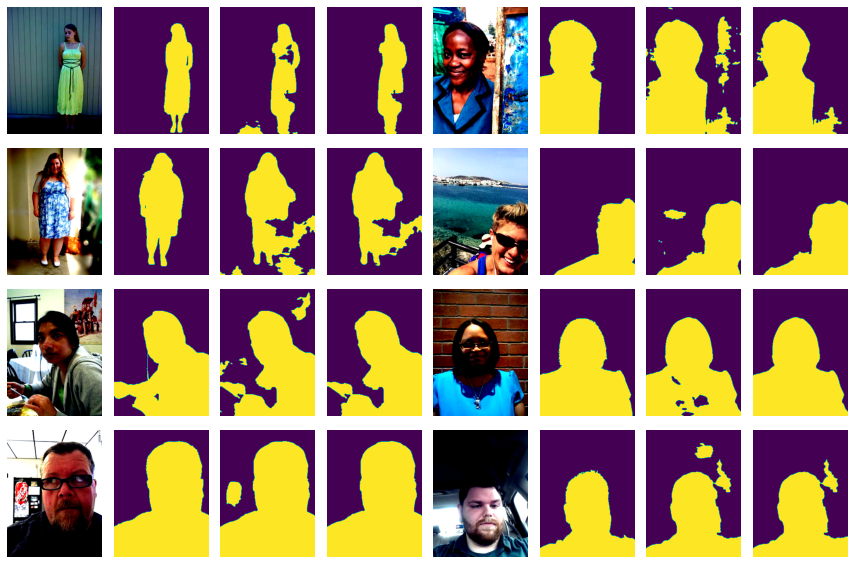

In [50]:
ssize = 8
inds = torch.topk(iou_posts - iou_raws, ssize, dim=0)[1].squeeze()
batch_x, batch_y, bin_output, post_output = (
    batch_xs[inds], batch_ys[inds],
    bin_outputs[inds], post_outputs[inds]
)

plt.figure(figsize=(12, 8))
for i in range(ssize // 2):
    for j in range(2):
        plt.subplot(ssize // 2, 8, 1 + i * 8 + j * 4)
        img = np.clip(batch_x[i * 2 + j].permute(1, 2, 0).numpy() * mean + std, 0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(ssize // 2, 8, 2 + i * 8 + j * 4)
        plt.imshow(batch_y[i * 2 + j].squeeze())
        plt.axis('off')
        plt.subplot(ssize // 2, 8, 3 + i * 8 + j * 4)
        plt.imshow(bin_output[i * 2 + j].squeeze())
        plt.axis('off')
        plt.subplot(ssize // 2, 8, 4 + i * 8 + j * 4)
        plt.imshow(post_output[i * 2 + j].squeeze())
        plt.axis('off')
plt.tight_layout()

<font color=blue>Здесь визуализированы четверки: исходная фотография (1), истинная маска (2), предсказанная маска (бинаризованная) без предобработки (3), предсказанная маска после постобработки (4).</font>

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: catalyst, pytorch-lightning, kekas.